In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch

import mbrl.planning as planning

%load_ext autoreload
%autoreload 2

%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['font.size'] = 16

In [3]:
def rosenbrock_fn(x_array, a=1., b=100.):
    n, d = x_array.shape
    assert d % 2 == 0
    val = 0
    for i in range(d // 2):
        x = x_array[:, 2 * i]
        y = x_array[:, 2 * i + 1]
        val += (a - x) ** 2 + b * (y - (x ** 2)) ** 2
    return -val

Best x: tensor([0.9955, 0.9909]), with value: tensor([-2.4705e-05])
Best x: tensor([0.9829, 0.9671]), with value: tensor([-0.0004])


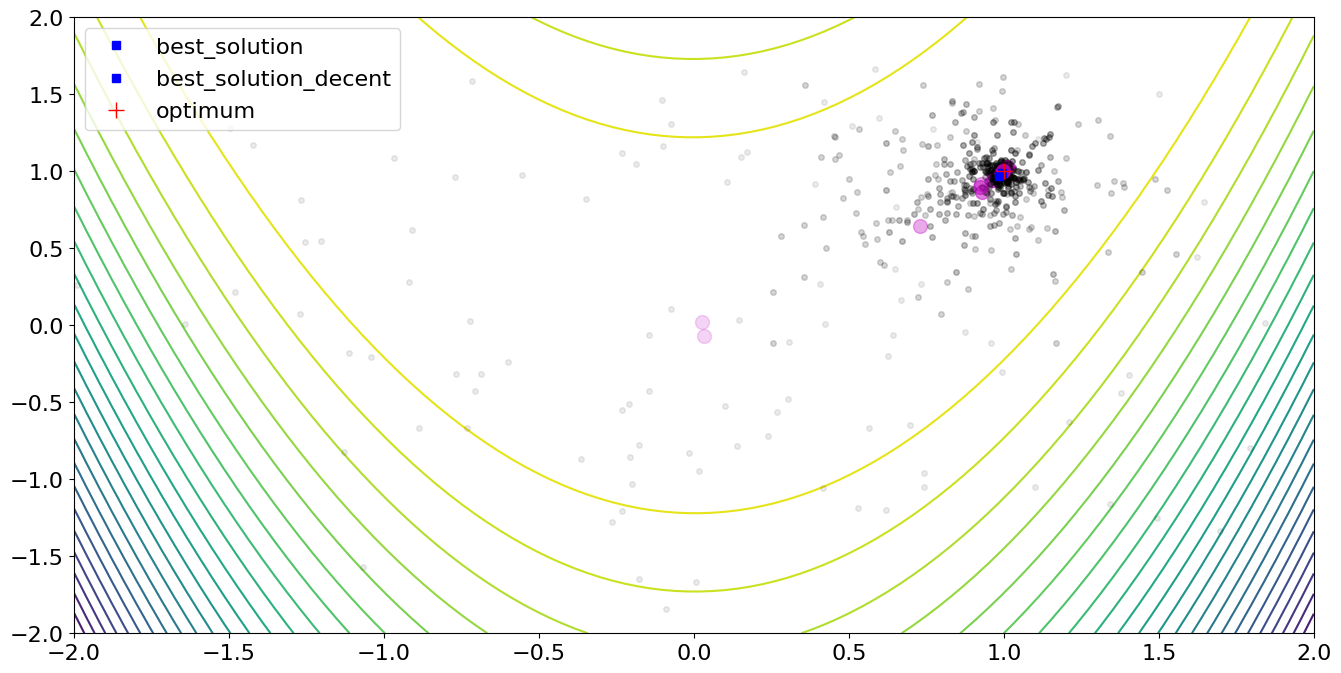

In [4]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

lb = [-2., -2.]
ub = [2., 2.]
n = 100
x1 = np.linspace(lb[0], ub[0], n) 
x2 = np.linspace(lb[1], ub[1], n)
x1s, x2s = np.meshgrid(x1, x2)
x = np.stack([x1s.flatten(), x2s.flatten()]).transpose()
z = rosenbrock_fn(x)
z = z.reshape((n, n))

ax.contour(x1s, x2s, z, levels=30)

iters = 5
max_values = np.zeros(iters)
mean_values = np.zeros(iters)
legend = []
def plot_population(population, values, it):
    mu_population = population.mean(0)
    ax.plot(population[::10,0], population[::10,1], 'ok', alpha=(it + 1) / (iters + 1) / 2, markersize=4)
    ax.plot(mu_population[0], mu_population[1], 'om', alpha=(it + 1) / (iters + 1), markersize=10)
    max_values[it] = values.max().item()
    mean_values[it] = values.mean().item()

# cem = planning.CEMOptimizer(iters, 0.01, 500, lb, ub, 0.1, torch.device("cpu"))
cem = planning.CEMOptimizer(iters, 0.01, 500, lb, ub, 0.1, torch.device("cpu"))
decentcem = planning.GMMCEMOptimizer(iters, 0.01, 100, lb, ub, 0.1, torch.device("cpu"), num_workers=5)
best = cem.optimize(rosenbrock_fn, torch.zeros(2), callback=plot_population)
best_decent= cem.optimize(rosenbrock_fn, torch.zeros(2), callback=plot_population)

best_value = rosenbrock_fn(best.reshape((1, -1)))
best_value_decent = rosenbrock_fn(best_decent.reshape((1, -1))) 
print(f"Best x: {best}, with value: {best_value}")
print(f"Best x: {best_decent}, with value: {best_value_decent}")
ax.plot(best[0], best[1], 'bs', label="best_solution")
ax.plot(best_decent[0], best_decent[1], 'bs', label="best_solution_decent")

ax.plot(1, 1, 'r+', markersize=12, label="optimum")
plt.legend()
plt.show()

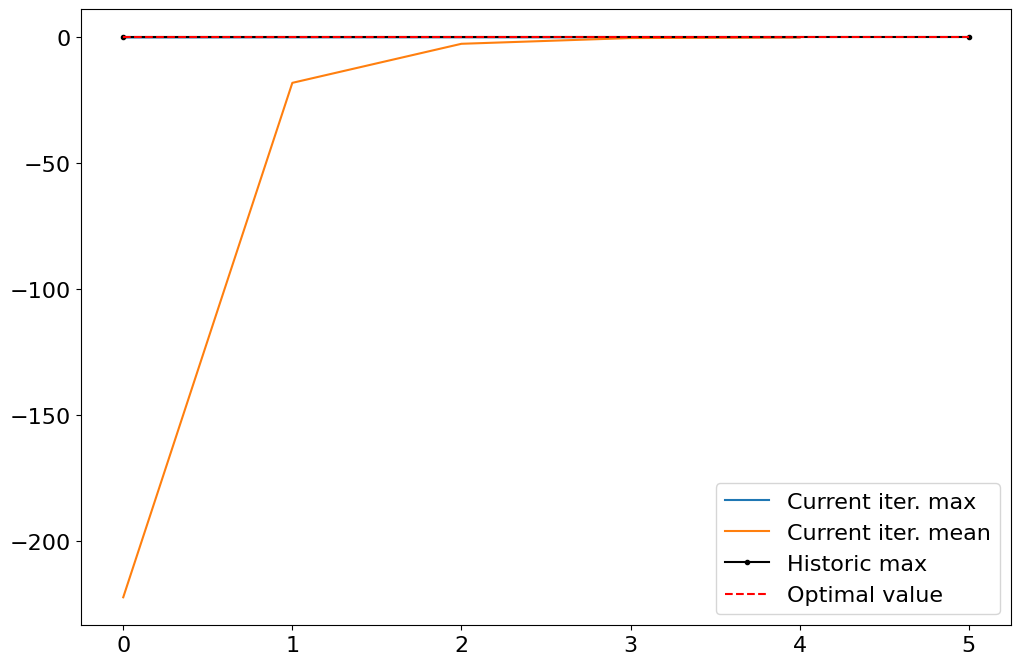

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(max_values)
plt.plot(mean_values)
plt.plot([0, iters], [best_value.item(), best_value.item()], 'k.-')
plt.plot([0, iters], [0, 0], 'r--')
plt.legend(["Current iter. max", "Current iter. mean", "Historic max", "Optimal value"])
plt.show()